In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass

In [2]:
sns.set(color_codes=True, style='whitegrid', context='paper')
plt.rcParams["figure.figsize"] = 15, 10

In [3]:
df = pd.read_csv(
    "play_data/XBTUSD_trades_191214_0434.csv",
    usecols=[
        "received",
        "size",
        "price"
    ],
    parse_dates=["received"],
    index_col="received",
    nrows=30000
)

In [4]:
class DollarWeightedMACD:
    @dataclass
    class DWMParameters:
        __slots__ = "group_width", "short_ma_window", "long_ma_window"
        group_width: float
        short_ma_window: int
        long_ma_window: int

    @dataclass
    class DWMCache:
        __slots__ = "ma_vals", "increasing", "curr_bar", "remaining_width"
        ma_vals: np.array  # each element is dwap, for each item in the window
        increasing: bool  # used to check direction changes to prevent duplicates
        curr_bar: pd.DataFrame  # columns: size, price, dollars
        remaining_width: float # when curr bar full, update MAs
        
    def make_dwap_df_and_curr_bar(self, df, group_width):
        df["dollars"] = df["size"] * df["price"]
        df["group"] = (df["dollars"].cumsum() // group_width)  # will be affected by different initial conditions
        new_series = {}  # timestamp : dollar weighted average price

        for grp, gdf in df.groupby("group"):
            timestamp = gdf.index[-1] # last timing, prevent lookahead
            dwap = (gdf["dollars"].values * gdf["price"].values).sum() / gdf["dollars"].values.sum()
            if grp == df["group"].max():
                curr_bar = gdf[["size", "price", "dollars"]].values  # for cache
            new_series[timestamp] = dwap
            
        ddf = pd.Series(new_series, name="dwap").to_frame()
        return ddf, curr_bar

    def __init__(self, df):
        group_width = 680850400  # arbitrary, eventually can dynamically adjust
        short_ma, long_ma = 5, 10  # maybe can EWM but will need more parameters
        
        self.ddf, curr_bar = self.make_dwap_df_and_curr_bar(df, group_width)
        
        ma_vals = self.ddf["dwap"].values[-long_ma:]
        increasing = ma_vals[-short_ma:].sum()/short_ma > ma_vals.sum()/long_ma
        rem_width = group_width - (df["dollars"].cumsum().values % group_width)[-1]

        self.cache = self.DWMCache(ma_vals, increasing, curr_bar, rem_width)
        self.params = self.DWMParameters(group_width, short_ma, long_ma)
        return None
        
    def generate_signal(self, size, price):  
        # also updates cache, inefficient
        # TODO: improve readability
        # TODO: rewrite such that chache update is separate
        
        new_row = np.array([[size, price, size*price]])
        dols = new_row[0,2]
        self.cache.remaining_width -= new_row[0,2]
        
        if self.cache.remaining_width > 0:  # old bar, update last val
            self.cache.curr_bar = np.append(self.cache.curr_bar, new_row, axis=0)
            
        else:  # new bar, does not account big txn that exceeds group width
            self.cache.remaining_width += self.params.group_width
            self.cache.curr_bar = new_row
            self.cache.ma_vals = np.roll(self.cache.ma_vals, -1)
            
        self.cache.ma_vals[-1] = ((self.cache.curr_bar[:,1] * self.cache.curr_bar[:,2]).sum() 
                                  / self.cache.curr_bar[:,2].sum())
        
        long_sma = self.cache.ma_vals.sum() / self.params.long_ma_window
        short_sma = self.cache.ma_vals[-self.params.short_ma_window:].sum()/self.params.short_ma_window
        inc = short_sma > long_sma
        old_inc = self.cache.increasing
        self.cache.increasing = inc
        
        # old_inc!=inc: whether there is a direction change
        # (-1)**(not inc): whether we want to long or short (1 if increasing, -1 if decreasing)
        return (old_inc!=inc) * (-1)**(not inc)
        
    def update_cache(self, size, price):
        # currently done inside generate signal
        # have to redo logic later if it works 
        print("updating cache")
        return None
    
    def update_parameters(self, df):
        # assumes df will be updated with all the relevant data
        print("updating parameters")
        return None

In [5]:
def _plot(df, dwap_strat):
    ax1 = df["price"].plot(label='raw price')
    plt.legend()
    
    ax2 = ax1.twinx()
    short_ma = dwap_strat.params.short_ma_window
    long_ma = dwap_strat.params.long_ma_window
    ddf = dwap_strat.ddf
    short_sma = ddf["dwap"].rolling(short_ma).mean()
    long_sma = ddf["dwap"].rolling(long_ma).mean()
    ax2.plot(short_sma-long_sma, label=f"{short_ma}MA-{long_ma}MA", c="0.25")
    plt.legend(loc="lower right")
    return None

1
0
-1
1


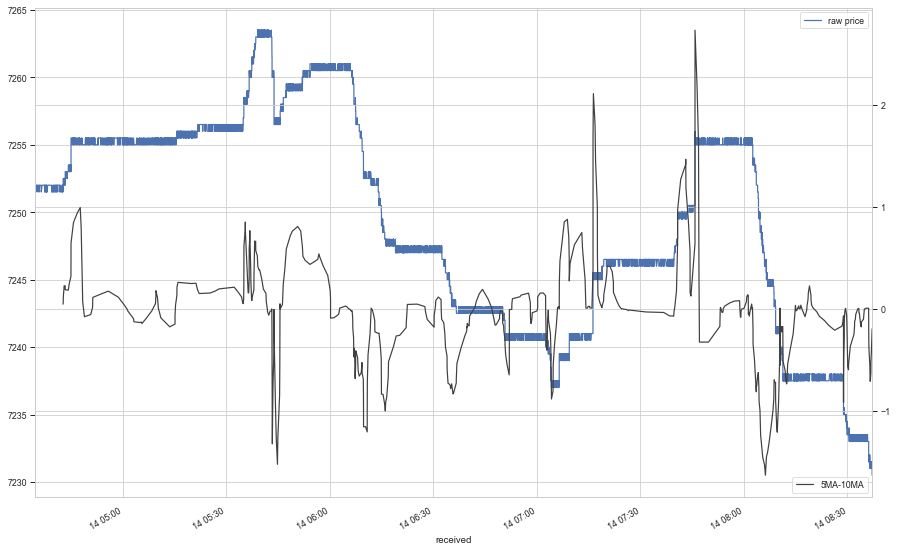

In [6]:
d = DollarWeightedMACD(df)

_plot(df, d)

print( d.generate_signal(100000, 7500) )
print( d.generate_signal(200000, 7000) )
print( d.generate_signal(100000, 7000) )
print( d.generate_signal(100000, 8000) )